Epoch 1/20


2024-08-03 01:29:50.679084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-08-03 01:29:50.733421: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


150/150 [==============================] - 12s 76ms/step - loss: 0.7058 - accuracy: 0.6283 - val_loss: 0.6228 - val_accuracy: 0.6767
Epoch 2/20
150/150 [==============================] - 11s 71ms/step - loss: 0.6097 - accuracy: 0.6658 - val_loss: 0.5679 - val_accuracy: 0.7167
Epoch 3/20
150/150 [==============================] - 11s 72ms/step - loss: 0.5879 - accuracy: 0.6850 - val_loss: 0.4789 - val_accuracy: 0.7900
Epoch 4/20
150/150 [==============================] - 11s 72ms/step - loss: 0.5623 - accuracy: 0.7146 - val_loss: 0.6966 - val_accuracy: 0.6600
Epoch 5/20
150/150 [==============================] - 11s 70ms/step - loss: 0.5323 - accuracy: 0.7392 - val_loss: 0.5626 - val_accuracy: 0.7100
Epoch 6/20
150/150 [==============================] - 11s 72ms/step - loss: 0.5113 - accuracy: 0.7483 - val_loss: 0.4664 - val_accuracy: 0.7783
Epoch 7/20
150/150 [==============================] - 11s 72ms/step - loss: 0.5040 - accuracy: 0.7558 - val_loss: 0.5205 - val_accuracy: 0.7850
Epo

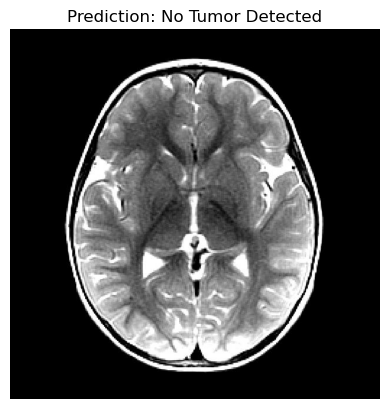

In [2]:
import numpy as np
import cv2 as cv
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.utils import normalize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.initializers import HeUniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Define the directory where images are stored
image_directory = '/Users/nandlalkumawat/Desktop/AI_phone/brain_tumor/brain_tumor2/archive'

# Initialize lists to hold image data and labels
dataset = []
label = []

# Process 'no' tumor images
no_tumor_images = os.listdir(os.path.join(image_directory, 'no'))

for image_name in no_tumor_images:
    if image_name.lower().endswith('.jpg'):  # Check if the file has a .jpg extension
        file_path = os.path.join(image_directory, 'no', image_name)  # Correct path concatenation

        if os.path.exists(file_path):
            image = cv.imread(file_path)

            if image is not None:
                image = Image.fromarray(cv.cvtColor(image, cv.COLOR_BGR2RGB))  # Convert color space
                image = image.resize((64, 64))
                dataset.append(np.array(image))
                label.append(0)
            else:
                print(f"Error: Unable to load image at {file_path}")
        else:
            print(f"Error: File not found at {file_path}")

# Process 'yes' tumor images
yes_tumor_images = os.listdir(os.path.join(image_directory, 'yes'))

for image_name in yes_tumor_images:
    if image_name.lower().endswith('.jpg'):
        file_path = os.path.join(image_directory, 'yes', image_name)

        if os.path.exists(file_path):
            image = cv.imread(file_path)

            if image is not None:
                image = Image.fromarray(cv.cvtColor(image, cv.COLOR_BGR2RGB))
                image = image.resize((64, 64))
                dataset.append(np.array(image))
                label.append(1)
            else:
                print(f"Error: Unable to load image at {file_path}")
        else:
            print(f"Error: File not found at {file_path}")

dataset = np.array(dataset)
label = np.array(label)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)

# Normalize the images
x_train = x_train / 255.0
x_test = x_test / 255.0

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)

# Define the model
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3), kernel_initializer=HeUniform()))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=HeUniform()))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=HeUniform()))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with data augmentation
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.fit(datagen.flow(x_train, y_train, batch_size=16),
          epochs=20,
          validation_data=(x_test, y_test),
          callbacks=[early_stopping])

# Preprocess image function
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((64, 64))
    image = np.array(image) / 255.0
    return np.expand_dims(image, axis=0)

# Predict image function
def predict_image(model, image_path):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)
    return prediction[0][0]

# Main function to execute the workflow
def main():
    image_path = '/Users/nandlalkumawat/Desktop/AI_phone/brain_tumor/brain_tumor2/archive/no/no0.jpg'  # Replace with your image path
    prediction = predict_image(model, image_path)
    
    image = Image.open(image_path)
    
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Prediction: {"Tumor Detected" if prediction > 0.5 else "No Tumor Detected"}')
    plt.show()

if __name__ == '__main__':
    main()
